In [27]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch

df = yf.download("AAPL", period="5y")
df['Return'] = np.log(df['Close'] / df['Close'].shift(1))
df = df.dropna()

data = df[['Return']].values.astype('float32')

C:\Users\Aksha\AppData\Local\Temp\ipykernel_4420\3436835386.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", period="5y")
[*********************100%***********************]  1 of 1 completed


In [29]:
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_len = 60
X, y = create_sequences(data, seq_len)

# ✅ FIX: do NOT unsqueeze
X = torch.tensor(X).float()        # Already (N, 60, 1)
y = torch.tensor(y).float()

train_size = int(len(X) * 0.8)

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]


In [31]:
import torch.nn as nn

class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

model = StockLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 500

for ep in range(epochs):
    model.train()
    pred = model(X_train)
    loss = criterion(pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (ep+1) % 5 == 0:
        print(ep+1, loss.item())

5 0.013004569336771965
10 0.007176776882261038
15 0.0034185952972620726
20 0.000835580809507519
25 0.0005112317157909274
30 0.000874822901096195
35 0.000343094376148656
40 0.00031578802736476064
45 0.00035189761547371745
50 0.00032666148035787046
55 0.00028459972236305475
60 0.0002834200859069824
65 0.00029090011958032846
70 0.0002844293776433915
75 0.0002849614538718015
80 0.0002860190870705992
85 0.0002822115202434361
90 0.00028496532468125224
95 0.00028617895441129804
100 0.00028558680787682533
105 0.0002875695936381817
110 0.0002858633524738252
115 0.00028467702213674784
120 0.0002809688448905945
125 0.00028296286473050714
130 0.00028696254594251513
135 0.0002842199755832553
140 0.00028829704388044775
145 0.0002828477299772203
150 0.0002814231556840241
155 0.0002850622695405036
160 0.00028390801162458956
165 0.00028109262348152697
170 0.0002819091023411602
175 0.0002798938367050141
180 0.000282411027001217
185 0.0002810075238812715
190 0.0002834005281329155
195 0.000285016139969229

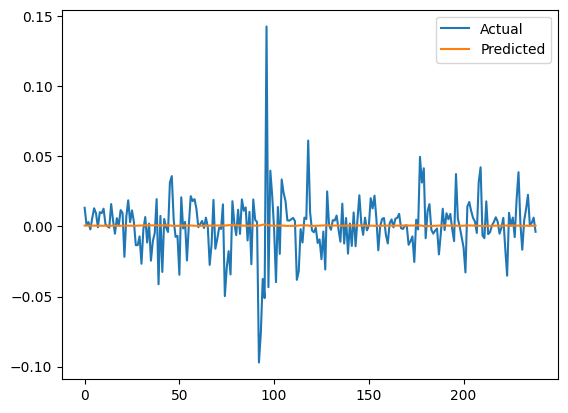

Next Day Prediction: 0.0005234777927398682


In [32]:
import matplotlib.pyplot as plt


model.eval()
pred_test = model(X_test).detach().numpy()
actual_test = y_test.numpy()


plt.plot(actual_test, label="Actual")
plt.plot(pred_test, label="Predicted")
plt.legend()
plt.show()

last_60 = data[-60:]                
last_60 = torch.tensor(last_60).float().unsqueeze(0)   
model.eval()
next_day = model(last_60).item()
print("Next Day Prediction:", next_day)